In [8]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *

import cv2
import open3d as o3d

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Second, assign features to segmented neurons and match neurons

# Load segmentation centroids
seg_fname0 = os.path.join(dat_foldername, 'test_vol0.txt')
seg_vol0 = np.loadtxt(seg_fname0)
# TODO: text files are saved in a reduced location space
neurons0 = np.array([bcpd_to_pixels(row) for row in seg_vol0])

seg_fname1 = os.path.join(dat_foldername, 'test_vol1.txt')
seg_vol1 = np.loadtxt(seg_fname1)
neurons1 = np.array([bcpd_to_pixels(row) for row in seg_vol1])

all_features0, all_features1, kp0, kp1 = build_features_and_match_2volumes('img100.tif','img101.tif',verbose=1, 
                                                            detect_keypoints=True,
                                                            kp0=neurons0,
                                                            kp1=neurons1)

In [7]:
# Build the point clouds and cluster
# From: http://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html
f0, pc_f0, tree_f0 = build_feature_tree(all_features0)


## Try 1: open3d built-in dbscan

In [42]:
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_cluster_labels

In [66]:
labels = np.array(pc_f0.cluster_dbscan(eps=1.5, min_points=5,print_progress=True))

In [74]:
visualize_cluster_labels(labels, pc_f0)

point cloud has 96 clusters


In [72]:
all_scores = []
X = pc_f0.points
vals = list(np.linspace(2.0,4.0,25))

for i in vals:
    labels = np.array(pc_f0.cluster_dbscan(eps=i, min_points=5))
    scores = silhouette_score(X,labels)
    all_scores.append(scores)

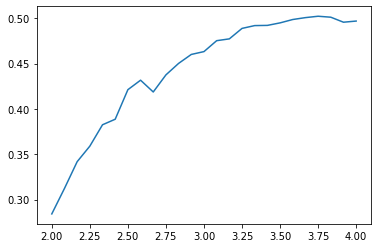

In [73]:
plt.plot(vals, all_scores)

## Try 2: scikit learn gmm


In [29]:
from sklearn.mixture import BayesianGaussianMixture

In [35]:
n_components = 100
random_state = 13

bgm = BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state)

In [36]:
bgm.fit(pc_f0.points)

BayesianGaussianMixture(init_params='random', max_iter=1500,
                        mean_precision_prior=0.8, n_components=200,
                        random_state=13, reg_covar=0,
                        weight_concentration_prior_type='dirichlet_distribution')

In [37]:
labels = bgm.predict(pc_f0.points)

In [43]:
visualize_labels(labels, pc_f0)

point cloud has 200 clusters


## Try 3: k-means

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [57]:
X = pc_f0.points
all_scores = []
#all_means = []

vals = list(range(100,200,10))

for i in vals:
    labels = KMeans(n_clusters=i, random_state=0).fit_predict(X)
    scores = silhouette_score(X,labels)
    all_scores.append(scores)
    #all_means.append(np.mean(scores))

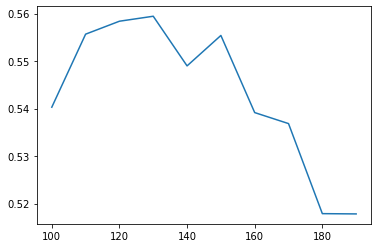

In [58]:
plt.plot(vals, all_scores)


In [59]:
visualize_labels(labels, pc_f0)

point cloud has 190 clusters
